# Importing Required Libraries

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

In [2]:
import os

INPUT_DATASET = "datasets/original"

BASE_PATH = "datasets/train_test"
TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])

TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2

In [ ]:
from imutils import paths
import random, shutil, os

originalPaths=list(paths.list_images(INPUT_DATASET))
random.seed(7)
random.shuffle(originalPaths)

index=int(len(originalPaths)*TRAIN_SPLIT)
trainPaths=originalPaths[:index]
testPaths=originalPaths[index:]

index=int(len(trainPaths)*VAL_SPLIT)
valPaths=trainPaths[:index]
trainPaths=trainPaths[index:]

datasets=[("training", trainPaths, TRAIN_PATH),
          ("validation", valPaths, VAL_PATH)
]

for (setType, originalPaths, basePath) in datasets:
        print(f'Building {setType} set')

        if not os.path.exists(basePath):
                print(f'Building directory {basePath}')
                os.makedirs(basePath)

        for path in originalPaths:
                file=path.split(os.path.sep)[-1]
                label=file[-5:-4]

                labelPath=os.path.sep.join([basePath,label])
                if not os.path.exists(labelPath):
                        print(f'Building directory {labelPath}')
                        os.makedirs(labelPath)

                newPath=os.path.sep.join([labelPath, file])
                shutil.copy2(path, newPath)

In [3]:
labels = ['0', '1']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


def get_data2(data_dir,label):
    data = [] 
    path = os.path.join(data_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
        try:
            img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
            
            resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
            data.append([resized_arr, class_num])
        except Exception as e:
            print(e)
    return np.array(data)

In [4]:
train = get_data('datasets/train_test/training')
val = get_data('datasets/train_test/validation')

'NoneType' object is not subscriptable


C:\Users\farih\AppData\Local\Temp/ipykernel_7532/3826227150.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [5]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [6]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [10]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Conv2D(16, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)       

In [12]:
opt = Adam(learning_rate=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [13]:
history = model.fit(x_train,y_train,epochs = 500 , validation_data = (x_val, y_val))

Epoch 1/500


C:\Users\farih\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\backend.py:4942: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


130/130 [==============================] - 393s 2s/step - loss: 0.3904 - accuracy: 0.8641 - val_loss: 0.4002 - val_accuracy: 0.8386
Epoch 2/500
130/130 [==============================] - 149s 1s/step - loss: 0.3492 - accuracy: 0.8660 - val_loss: 0.3975 - val_accuracy: 0.8386
Epoch 3/500
130/130 [==============================] - 150s 1s/step - loss: 0.3450 - accuracy: 0.8660 - val_loss: 0.3906 - val_accuracy: 0.8386
Epoch 4/500
130/130 [==============================] - 154s 1s/step - loss: 0.3395 - accuracy: 0.8660 - val_loss: 0.3886 - val_accuracy: 0.8386
Epoch 5/500
130/130 [==============================] - 158s 1s/step - loss: 0.3342 - accuracy: 0.8660 - val_loss: 0.3714 - val_accuracy: 0.8386
Epoch 6/500
130/130 [==============================] - 161s 1s/step - loss: 0.3243 - accuracy: 0.8660 - val_loss: 0.3659 - val_accuracy: 0.8386
Epoch 7/500
130/130 [==============================] - 156s 1s/step - loss: 0.3141 - accuracy: 0.8660 - val_loss: 0.3535 - val_accuracy: 0.8386
Epoc

130/130 [==============================] - 157s 1s/step - loss: 0.1918 - accuracy: 0.9213 - val_loss: 0.2262 - val_accuracy: 0.9034
Epoch 114/500
130/130 [==============================] - 157s 1s/step - loss: 0.1940 - accuracy: 0.9206 - val_loss: 0.2230 - val_accuracy: 0.9024
Epoch 115/500
130/130 [==============================] - 157s 1s/step - loss: 0.1917 - accuracy: 0.9220 - val_loss: 0.2248 - val_accuracy: 0.9024
Epoch 116/500
130/130 [==============================] - 158s 1s/step - loss: 0.1921 - accuracy: 0.9235 - val_loss: 0.2273 - val_accuracy: 0.9043
Epoch 117/500
130/130 [==============================] - 157s 1s/step - loss: 0.1916 - accuracy: 0.9220 - val_loss: 0.2232 - val_accuracy: 0.9014
Epoch 118/500
130/130 [==============================] - 157s 1s/step - loss: 0.1925 - accuracy: 0.9228 - val_loss: 0.2236 - val_accuracy: 0.9014
Epoch 119/500
130/130 [==============================] - 157s 1s/step - loss: 0.1902 - accuracy: 0.9230 - val_loss: 0.2229 - val_accuracy:

130/130 [==============================] - 159s 1s/step - loss: 0.1732 - accuracy: 0.9307 - val_loss: 0.2188 - val_accuracy: 0.9043
Epoch 226/500
130/130 [==============================] - 158s 1s/step - loss: 0.1750 - accuracy: 0.9290 - val_loss: 0.2259 - val_accuracy: 0.9043
Epoch 227/500
130/130 [==============================] - 158s 1s/step - loss: 0.1762 - accuracy: 0.9266 - val_loss: 0.2159 - val_accuracy: 0.9043
Epoch 228/500
130/130 [==============================] - 160s 1s/step - loss: 0.1749 - accuracy: 0.9271 - val_loss: 0.2165 - val_accuracy: 0.9063
Epoch 229/500
130/130 [==============================] - 160s 1s/step - loss: 0.1721 - accuracy: 0.9293 - val_loss: 0.2157 - val_accuracy: 0.9053
Epoch 230/500
130/130 [==============================] - 161s 1s/step - loss: 0.1762 - accuracy: 0.9283 - val_loss: 0.2180 - val_accuracy: 0.9063
Epoch 231/500
130/130 [==============================] - 159s 1s/step - loss: 0.1746 - accuracy: 0.9281 - val_loss: 0.2184 - val_accuracy:

130/130 [==============================] - 166s 1s/step - loss: 0.1568 - accuracy: 0.9404 - val_loss: 0.2187 - val_accuracy: 0.9043
Epoch 338/500
130/130 [==============================] - 168s 1s/step - loss: 0.1597 - accuracy: 0.9399 - val_loss: 0.2146 - val_accuracy: 0.9082
Epoch 339/500
130/130 [==============================] - 166s 1s/step - loss: 0.1560 - accuracy: 0.9399 - val_loss: 0.2162 - val_accuracy: 0.9053
Epoch 340/500
130/130 [==============================] - 164s 1s/step - loss: 0.1576 - accuracy: 0.9385 - val_loss: 0.2124 - val_accuracy: 0.9092
Epoch 341/500
130/130 [==============================] - 166s 1s/step - loss: 0.1581 - accuracy: 0.9401 - val_loss: 0.2128 - val_accuracy: 0.9082
Epoch 342/500
130/130 [==============================] - 166s 1s/step - loss: 0.1578 - accuracy: 0.9389 - val_loss: 0.2122 - val_accuracy: 0.9092
Epoch 343/500
130/130 [==============================] - 164s 1s/step - loss: 0.1577 - accuracy: 0.9380 - val_loss: 0.2178 - val_accuracy:

130/130 [==============================] - 158s 1s/step - loss: 0.1443 - accuracy: 0.9457 - val_loss: 0.2084 - val_accuracy: 0.9121
Epoch 450/500
130/130 [==============================] - 152s 1s/step - loss: 0.1446 - accuracy: 0.9418 - val_loss: 0.2090 - val_accuracy: 0.9111
Epoch 451/500
130/130 [==============================] - 155s 1s/step - loss: 0.1430 - accuracy: 0.9442 - val_loss: 0.2087 - val_accuracy: 0.9111
Epoch 452/500
130/130 [==============================] - 165s 1s/step - loss: 0.1435 - accuracy: 0.9455 - val_loss: 0.2103 - val_accuracy: 0.9092
Epoch 453/500
130/130 [==============================] - 160s 1s/step - loss: 0.1434 - accuracy: 0.9442 - val_loss: 0.2107 - val_accuracy: 0.9082
Epoch 454/500
130/130 [==============================] - 162s 1s/step - loss: 0.1426 - accuracy: 0.9457 - val_loss: 0.2097 - val_accuracy: 0.9101
Epoch 455/500
130/130 [==============================] - 163s 1s/step - loss: 0.1440 - accuracy: 0.9438 - val_loss: 0.2075 - val_accuracy:

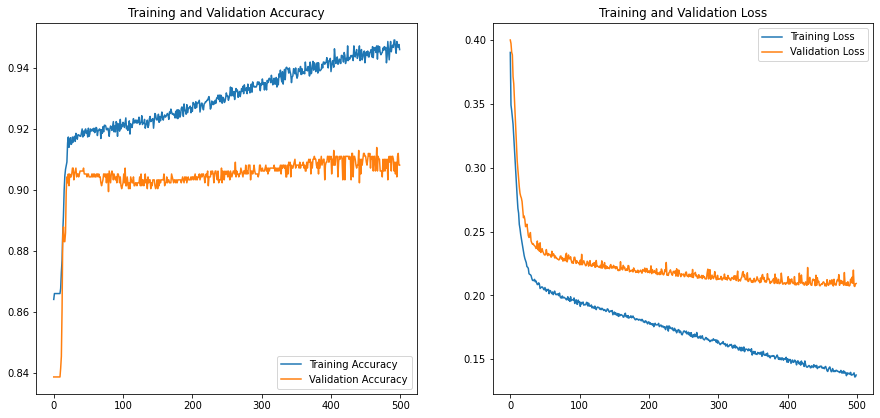

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

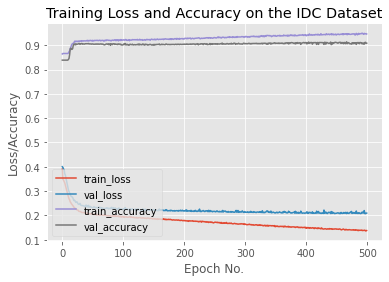

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

N=500
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), history.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0,N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy on the IDC Dataset")
plt.xlabel("Epoch No.")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [17]:
predictions = model.predict(x_val)
predictions=np.argmax(predictions,axis=1)
#predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = ['Non-idc','idc']))

              precision    recall  f1-score   support

     Non-idc       0.93      0.96      0.95       868
         idc       0.76      0.63      0.69       167

    accuracy                           0.91      1035
   macro avg       0.85      0.80      0.82      1035
weighted avg       0.90      0.91      0.90      1035



# Transfer Learning 

In [18]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights = "imagenet")

9412608/9406464 [==============================] - 4s 0us/step


In [19]:
base_model.trainable = False

In [20]:
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(2, activation="softmax")                                     
                                ])

In [24]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model.fit(x_train,y_train,epochs = 500 , validation_data = (x_val, y_val))

Epoch 1/500


C:\Users\farih\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\backend.py:4942: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


130/130 [==============================] - 285s 2s/step - loss: 0.5222 - accuracy: 0.7610 - val_loss: 0.4373 - val_accuracy: 0.8251
Epoch 2/500
130/130 [==============================] - 123s 947ms/step - loss: 0.4234 - accuracy: 0.8320 - val_loss: 0.4142 - val_accuracy: 0.8386
Epoch 3/500
130/130 [==============================] - 124s 957ms/step - loss: 0.3952 - accuracy: 0.8523 - val_loss: 0.4037 - val_accuracy: 0.8377
Epoch 4/500
130/130 [==============================] - 122s 937ms/step - loss: 0.3878 - accuracy: 0.8593 - val_loss: 0.3933 - val_accuracy: 0.8386
Epoch 5/500
130/130 [==============================] - 117s 904ms/step - loss: 0.3701 - accuracy: 0.8643 - val_loss: 0.3826 - val_accuracy: 0.8396
Epoch 6/500
130/130 [==============================] - 117s 904ms/step - loss: 0.3557 - accuracy: 0.8699 - val_loss: 0.3725 - val_accuracy: 0.8406
Epoch 7/500
130/130 [==============================] - 121s 934ms/step - loss: 0.3504 - accuracy: 0.8699 - val_loss: 0.3619 - val_acc

130/130 [==============================] - 117s 903ms/step - loss: 0.1977 - accuracy: 0.9257 - val_loss: 0.2101 - val_accuracy: 0.9140
Epoch 112/500
130/130 [==============================] - 118s 907ms/step - loss: 0.1911 - accuracy: 0.9237 - val_loss: 0.2103 - val_accuracy: 0.9130
Epoch 113/500
130/130 [==============================] - 114s 879ms/step - loss: 0.1869 - accuracy: 0.9259 - val_loss: 0.2098 - val_accuracy: 0.9140
Epoch 114/500
130/130 [==============================] - 117s 904ms/step - loss: 0.1908 - accuracy: 0.9249 - val_loss: 0.2099 - val_accuracy: 0.9130
Epoch 115/500
130/130 [==============================] - 116s 897ms/step - loss: 0.1900 - accuracy: 0.9269 - val_loss: 0.2096 - val_accuracy: 0.9140
Epoch 116/500
130/130 [==============================] - 116s 892ms/step - loss: 0.1868 - accuracy: 0.9269 - val_loss: 0.2090 - val_accuracy: 0.9140
Epoch 117/500
130/130 [==============================] - 115s 887ms/step - loss: 0.1913 - accuracy: 0.9230 - val_loss: 0

130/130 [==============================] - 116s 890ms/step - loss: 0.1773 - accuracy: 0.9317 - val_loss: 0.1981 - val_accuracy: 0.9130
Epoch 167/500
130/130 [==============================] - 117s 899ms/step - loss: 0.1704 - accuracy: 0.9336 - val_loss: 0.1983 - val_accuracy: 0.9130
Epoch 168/500
130/130 [==============================] - 115s 889ms/step - loss: 0.1718 - accuracy: 0.9319 - val_loss: 0.1980 - val_accuracy: 0.9130
Epoch 169/500
130/130 [==============================] - 116s 893ms/step - loss: 0.1726 - accuracy: 0.9319 - val_loss: 0.1975 - val_accuracy: 0.9130
Epoch 170/500
130/130 [==============================] - 116s 897ms/step - loss: 0.1769 - accuracy: 0.9324 - val_loss: 0.1976 - val_accuracy: 0.9130
Epoch 171/500
130/130 [==============================] - 117s 899ms/step - loss: 0.1738 - accuracy: 0.9317 - val_loss: 0.1974 - val_accuracy: 0.9130
Epoch 172/500
130/130 [==============================] - 115s 888ms/step - loss: 0.1739 - accuracy: 0.9302 - val_loss: 0

KeyboardInterrupt: 

In [48]:
from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced',
                                                # np.unique(train),
                                                 #train)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# Building the Classifier

In [3]:
#initializing CNN
classifier = Sequential()

In [4]:
#Convolution
#32 feature detectors (32 feature maps) , 3X3 feature dimension
classifier.add(Convolution2D(32,(3,3), input_shape=(48,48,3), activation='relu'))

In [5]:
#pooling
classifier.add(MaxPooling2D(pool_size=(2,2)))

In [6]:
classifier.add(Flatten())

In [7]:
classifier.add(Dense(128, activation = 'relu'))
classifier.add(Dense(1, activation = 'sigmoid'))

In [8]:
classifier.compile(optimizer ='adam', loss='binary_crossentropy',metrics = ['accuracy'])

# Image Pre-Processing

In [9]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

In [10]:
test_datagen = ImageDataGenerator(
    rescale = 1./255)

In [11]:
training_set= train_datagen.flow_from_directory('datasets/train_test/training',
                                               target_size = (48,48),
                                               batch_size = 32,
                                               class_mode = 'binary')

Found 4144 images belonging to 2 classes.


In [12]:
test_set= test_datagen.flow_from_directory('datasets/train_test/validation',
                                               target_size = (48,48),
                                               batch_size = 32,
                                               class_mode = 'binary')

Found 1035 images belonging to 2 classes.


# Fitting CNN to Images

In [14]:
classifier.fit(training_set, 
                         steps_per_epoch = 4144,
                         epochs = 25,
                         validation_data = test_set,
                         validation_steps=1035)

Epoch 1/25
  34/4144 [..............................] - ETA: 8:23 - loss: 0.3106 - accuracy: 0.8631 ETA: 8:44 - loss: 0.3110 - ac

UnknownError:  UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x000001B78041B450>
Traceback (most recent call last):

  File "C:\Users\farih\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\script_ops.py", line 249, in __call__
    ret = func(*args)

  File "C:\Users\farih\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\autograph\impl\api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\farih\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 892, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\farih\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\data_adapter.py", line 839, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\farih\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\data_adapter.py", line 965, in generator_fn
    yield x[i]

  File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras_preprocessing\image\iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras_preprocessing\image\iterator.py", line 227, in _get_batches_of_transformed_samples
    img = load_img(filepaths[j],

  File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras_preprocessing\image\utils.py", line 114, in load_img
    img = pil_image.open(io.BytesIO(f.read()))

  File "E:\Anaconda\envs\tensorflow\lib\site-packages\PIL\Image.py", line 3023, in open
    raise UnidentifiedImageError(

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x000001B78041B450>


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_723]

Function call stack:
train_function


In [ ]:
zero_train = get_data2('datasets/train_test/training','0')
one_train = get_data2('datasets/train_test/training','1')

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE
counter=Counter(zero_train)
print(counter)

Text(0.5, 1.0, '0')

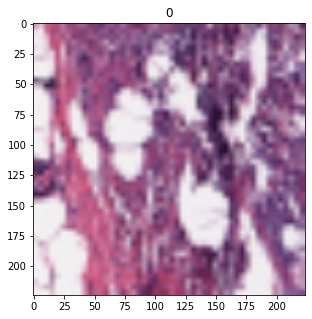

In [24]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, '1')

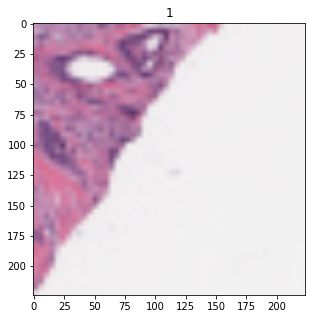

In [25]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [ ]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

In [1]:
#importing necessary libraries
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
img = cv2.imread('datasets/original/8864/0/8864_idx5_x51_y2251_class0.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [31]:
print(img.shape)

(50, 50, 3)


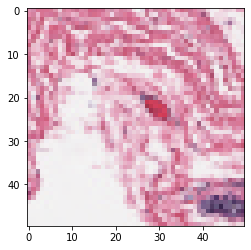

In [32]:
plt.imshow(img)

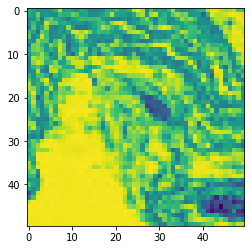

In [33]:
img = Image.open('datasets/original/8864/0/8864_idx5_x51_y2251_class0.png').convert('L')
plt.imshow(img)